In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install scikit-learn

Tuning XGBoost...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=30, min_child_weight=1, n_estimators=400, subsample=0.6; total time= 1.9min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=30, min_child_weight=1, n_estimators=400, subsample=0.6; total time= 2.2min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=30, min_child_weight=5, n_estimators=400, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=30, min_child_weight=5, n_estimators=400, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  35.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  37.5s
[CV] END colsample_bytree=0.8, gamma=0.2, 

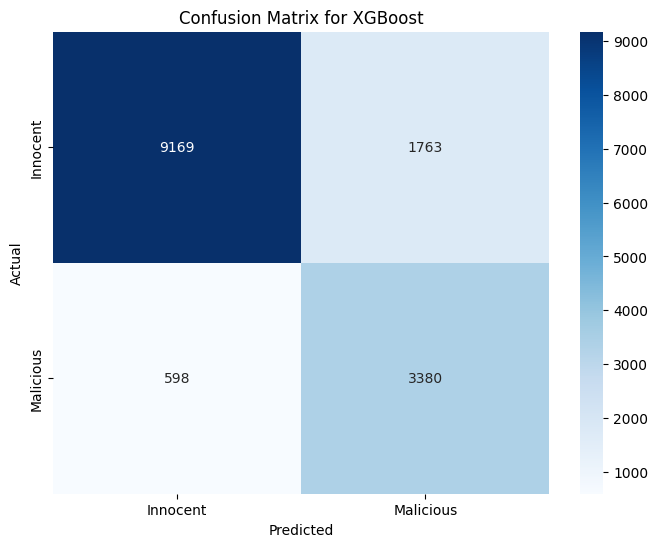


RandomForest Classification Report:
              precision    recall  f1-score   support

    Innocent       0.92      0.85      0.88     10932
   Malicious       0.65      0.79      0.72      3978

    accuracy                           0.83     14910
   macro avg       0.79      0.82      0.80     14910
weighted avg       0.85      0.83      0.84     14910


RandomForest Confusion Matrix:
[[9274 1658]
 [ 841 3137]]


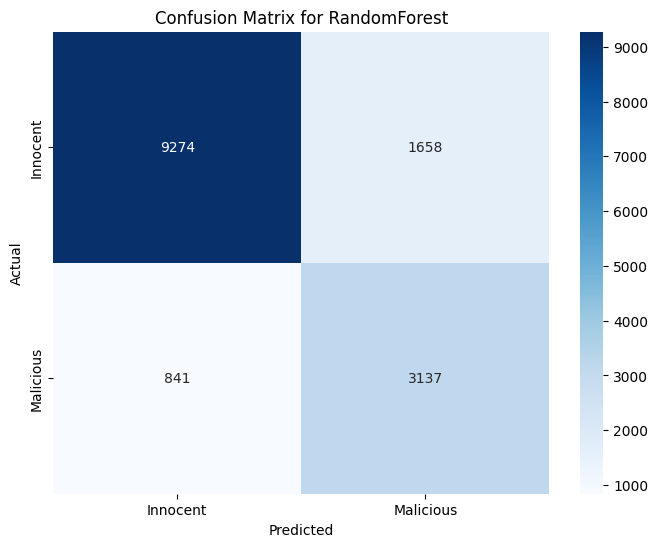


LogisticRegression Classification Report:
              precision    recall  f1-score   support

    Innocent       0.93      0.83      0.88     10932
   Malicious       0.64      0.84      0.73      3978

    accuracy                           0.83     14910
   macro avg       0.79      0.84      0.80     14910
weighted avg       0.86      0.83      0.84     14910


LogisticRegression Confusion Matrix:
[[9091 1841]
 [ 636 3342]]


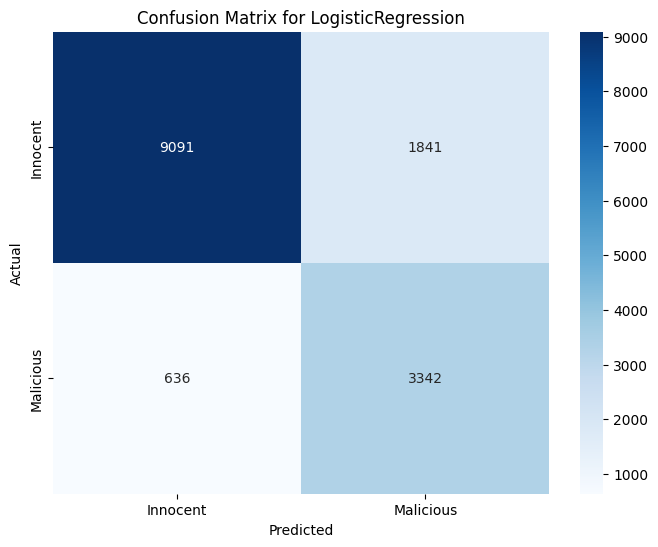


SVM Classification Report:
              precision    recall  f1-score   support

    Innocent       0.90      0.92      0.91     10932
   Malicious       0.76      0.72      0.74      3978

    accuracy                           0.86     14910
   macro avg       0.83      0.82      0.82     14910
weighted avg       0.86      0.86      0.86     14910


SVM Confusion Matrix:
[[10008   924]
 [ 1094  2884]]


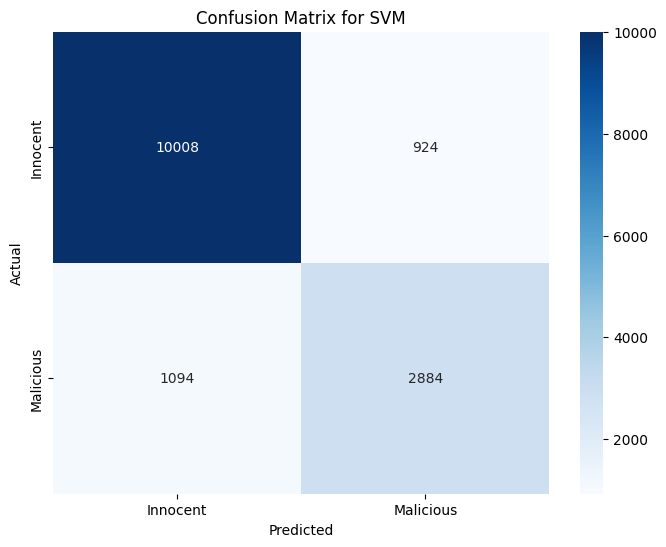

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np

# Load the training dataset
train_file_path = 'train_dataset_stratified.csv'
train_dataset = pd.read_csv(train_file_path)

# Create a new binary target column (0: innocent, 1: malicious)
train_dataset['binary_target'] = train_dataset['target'].apply(lambda x: 0 if x == 0 else 1)

# Combine text features into a single input feature
train_dataset['text_input'] = train_dataset['triggerTitle'] + ' ' + train_dataset['actionTitle'] + ' ' + train_dataset['desc']
train_dataset['text_input'] = train_dataset['text_input'].fillna('')  # Fill NaN values

# Prepare the training data
X_train = train_dataset['text_input']
y_train = train_dataset['binary_target']

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Create the TF-IDF vectorizer and transform the text data into numerical format (with trigrams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000, stop_words='english')  # Use trigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to balance the dataset after transforming the text into numerical features
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Model List: XGBoost, RandomForest, Logistic Regression, SVM
models = {
    "XGBoost": XGBClassifier(
        scale_pos_weight=class_weights[1] / class_weights[0],
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Hyperparameter tuning for each model
param_grids = {
    "XGBoost": {
        'n_estimators': [200, 300, 400],
        'max_depth': [10, 20, 30],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    },
    "RandomForest": {
        'n_estimators': [200, 300, 400],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Dictionary to store the best models and results
best_models = {}
results = {}

# Tune each model using RandomizedSearchCV
for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    grid_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=5,
        cv=2,
        scoring='f1',
        verbose=2,
        n_jobs=1
    )
    grid_search.fit(X_train_res, y_train_res)
    best_models[model_name] = grid_search.best_estimator_

    # Evaluate using cross-validation (F1-score)
    cv_scores = cross_val_score(best_models[model_name], X_train_res, y_train_res, cv=5, scoring='f1')
    results[model_name] = {
        "F1 Score": np.mean(cv_scores)
    }

# Print the results
print("\nCross-Validation Results:")
for model_name, result in results.items():
    print(f"{model_name}: F1 Score = {result['F1 Score']:.4f}")

# Load the test dataset
test_file_path = 'test_dataset_stratified.csv'  # Update with the path to your test dataset
test_dataset = pd.read_csv(test_file_path)

# Prepare the test dataset
test_dataset['binary_target'] = test_dataset['target'].apply(lambda x: 0 if x == 0 else 1)
test_dataset['text_input'] = test_dataset['triggerTitle'] + ' ' + test_dataset['actionTitle'] + ' ' + test_dataset['desc']
test_dataset['text_input'] = test_dataset['text_input'].fillna('')  # Fill NaN values

# Transform the test text data using the same TF-IDF vectorizer
X_test = test_dataset['text_input']
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Extract the test labels
y_test = test_dataset['binary_target']

# Predict and evaluate each model
for model_name, model in best_models.items():
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Probability for the "Malicious" class
    threshold = 0.45  # threshold for precision-recall trade-off
    y_pred = (y_prob >= threshold).astype(int)

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Innocent', 'Malicious']))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Innocent', 'Malicious'], yticklabels=['Innocent', 'Malicious'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [ ]:
import joblib

# Save each model to a separate file
for model_name, model in best_models.items():
    filename = f"{model_name}_best_model.joblib"
    joblib.dump(model, filename)
    print(f"Saved {model_name} to {filename}")


Saved XGBoost to XGBoost_best_model.joblib
Saved RandomForest to RandomForest_best_model.joblib
Saved LogisticRegression to LogisticRegression_best_model.joblib
Saved SVM to SVM_best_model.joblib


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   6.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   6.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   2.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   2.0s
[CV] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   2.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10; total time=   0.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=5, min_samples_split=10; total time=   4.5s
[CV] END max_

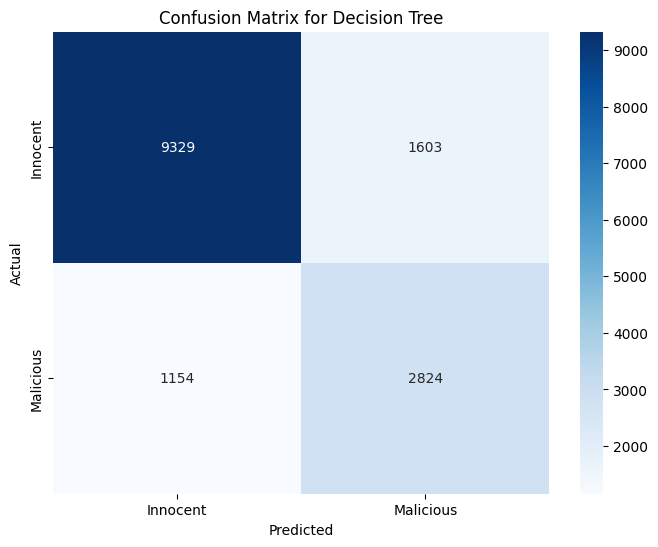

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier  # Importing DecisionTreeClassifier
import numpy as np

# Load the training dataset
train_file_path = 'train_dataset_stratified.csv'
train_dataset = pd.read_csv(train_file_path)

# Create a new binary target column (0: innocent, 1: malicious)
train_dataset['binary_target'] = train_dataset['target'].apply(lambda x: 0 if x == 0 else 1)

# Combine text features into a single input feature
train_dataset['text_input'] = train_dataset['triggerTitle'] + ' ' + train_dataset['actionTitle'] + ' ' + train_dataset['desc']
train_dataset['text_input'] = train_dataset['text_input'].fillna('')  # Fill NaN values

# Prepare the training data
X_train = train_dataset['text_input']
y_train = train_dataset['binary_target']

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Create the TF-IDF vectorizer and transform the text data into numerical format (with trigrams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000, stop_words='english')  # Use trigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to balance the dataset after transforming the text into numerical features
smote = SMOTE(sampling_strategy='minority', random_state=42)  # Use 'minority' strategy
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Tune the Decision Tree model using RandomizedSearchCV
grid_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='f1',
    verbose=2,
    n_jobs=1
)
grid_search.fit(X_train_res, y_train_res)

# Use the best model found by RandomizedSearchCV
best_model = grid_search.best_estimator_

# Evaluate using cross-validation (F1-score)
cv_scores = cross_val_score(best_model, X_train_res, y_train_res, cv=5, scoring='f1')
print(f"\nDecision Tree F1 Score (Cross-Validation): {np.mean(cv_scores):.4f}")

# Load the test dataset
test_file_path = 'test_dataset_stratified.csv'  # Update with the path to your test dataset
test_dataset = pd.read_csv(test_file_path)

# Prepare the test dataset
test_dataset['binary_target'] = test_dataset['target'].apply(lambda x: 0 if x == 0 else 1)
test_dataset['text_input'] = test_dataset['triggerTitle'] + ' ' + test_dataset['actionTitle'] + ' ' + test_dataset['desc']
test_dataset['text_input'] = test_dataset['text_input'].fillna('')  # Fill NaN values

# Transform the test text data using the same TF-IDF vectorizer
X_test = test_dataset['text_input']
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Extract the test labels
y_test = test_dataset['binary_target']

# Predict and evaluate the Decision Tree model
y_prob = best_model.predict_proba(X_test_tfidf)[:, 1]  # Probability for the "Malicious" class
threshold = 0.45  # threshold for precision-recall trade-off
y_pred = (y_prob >= threshold).astype(int)

# Print the classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Innocent', 'Malicious']))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nDecision Tree Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Innocent', 'Malicious'], yticklabels=['Innocent', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Decision Tree')
plt.show()


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=30, min_child_weight=1, n_estimators=300, subsample=1.0; total time= 4.7min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=30, min_child_weight=1, n_estimators=300, subsample=1.0; total time= 5.7min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=30, min_child_weight=1, n_estimators=400, subsample=0.6; total time= 1.9min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=30, min_child_weight=1, n_estimators=400, subsample=0.6; total time= 2.2min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=30, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=30, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.

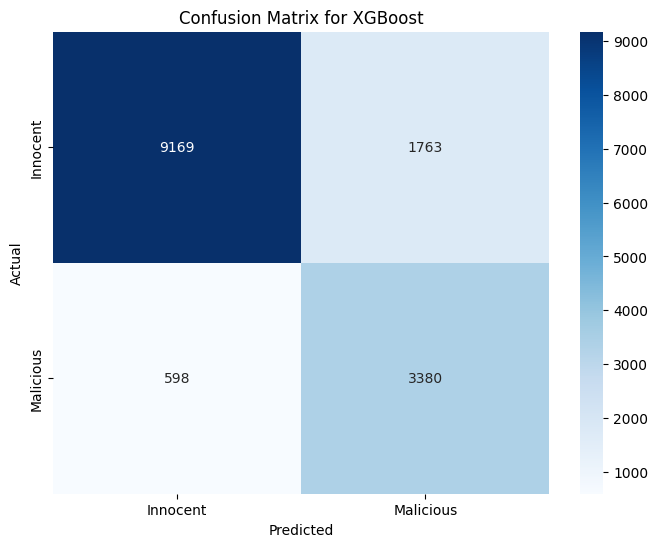

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier  # Importing XGBoost
import numpy as np

# Load the training dataset
train_file_path = 'train_dataset_stratified.csv'
train_dataset = pd.read_csv(train_file_path)

# Create a new binary target column (0: innocent, 1: malicious)
train_dataset['binary_target'] = train_dataset['target'].apply(lambda x: 0 if x == 0 else 1)

# Combine text features into a single input feature
train_dataset['text_input'] = train_dataset['triggerTitle'] + ' ' + train_dataset['actionTitle'] + ' ' + train_dataset['desc']
train_dataset['text_input'] = train_dataset['text_input'].fillna('')  # Fill NaN values

# Prepare the training data
X_train = train_dataset['text_input']
y_train = train_dataset['binary_target']

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Create the TF-IDF vectorizer and transform the text data into numerical format (with trigrams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000, stop_words='english')  # Use trigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to balance the dataset after transforming the text into numerical features
smote = SMOTE(sampling_strategy='minority', random_state=42)  # Use 'minority' strategy
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# XGBoost model
model = XGBClassifier(
    scale_pos_weight=class_weights[1] / class_weights[0],
    random_state=42
)

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Tune the XGBoost model using RandomizedSearchCV
grid_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='f1',
    verbose=2,
    n_jobs=1
)
grid_search.fit(X_train_res, y_train_res)

# Use the best model found by RandomizedSearchCV
best_model = grid_search.best_estimator_

# Evaluate using cross-validation (F1-score)
cv_scores = cross_val_score(best_model, X_train_res, y_train_res, cv=5, scoring='f1')
print(f"\nXGBoost F1 Score (Cross-Validation): {np.mean(cv_scores):.4f}")

# Load the test dataset
test_file_path = 'test_dataset_stratified.csv'  # Update with the path to your test dataset
test_dataset = pd.read_csv(test_file_path)

# Prepare the test dataset
test_dataset['binary_target'] = test_dataset['target'].apply(lambda x: 0 if x == 0 else 1)
test_dataset['text_input'] = test_dataset['triggerTitle'] + ' ' + test_dataset['actionTitle'] + ' ' + test_dataset['desc']
test_dataset['text_input'] = test_dataset['text_input'].fillna('')  # Fill NaN values

# Transform the test text data using the same TF-IDF vectorizer
X_test = test_dataset['text_input']
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Extract the test labels
y_test = test_dataset['binary_target']

# Predict and evaluate the XGBoost model
y_prob = best_model.predict_proba(X_test_tfidf)[:, 1]  # Probability for the "Malicious" class
threshold = 0.45  # Adjust threshold for precision-recall trade-off
y_pred = (y_prob >= threshold).astype(int)

# Print the classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Innocent', 'Malicious']))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nXGBoost Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Innocent', 'Malicious'], yticklabels=['Innocent', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for XGBoost')
plt.show()


In [ ]:
import joblib
import pickle

# Save the XGBoost model using joblib
model_save_path = 'xgboost_best_model.joblib'
joblib.dump(best_model, model_save_path)
print(f"XGBoost model saved to: {model_save_path}")

# Save the TF-IDF vectorizer using pickle
vectorizer_save_path = 'tfidf_vectorizer.pkl'
with open(vectorizer_save_path, 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)
print(f"TF-IDF vectorizer saved to: {vectorizer_save_path}")


XGBoost model saved to: xgboost_best_model.joblib
TF-IDF vectorizer saved to: tfidf_vectorizer.pkl
